$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal{#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\ip}[3]{\left<#1,#2\right>_{#3}}
\newcommand{\given}[]{\,\middle\vert\,}
\newcommand{\DKL}[2]{\cset{D}_{\text{KL}}\left(#1\,\Vert\, #2\right)}
\newcommand{\grad}[]{\nabla}
$$

# Part 3: Mini-Project
<a id=part3></a>

In this part you'll implement a small comparative-analysis project, heavily based on the materials from the tutorials and homework.

You must **choose one** of the project options specified below.

### Guidelines

- You should implement the code which displays your results in this notebook, and add any additional code files for your implementation in the `project/` directory. You can import these files here, as we do for the homeworks.
- Running this notebook should not perform any training - load your results from some output files and display them here. The notebook must be runnable from start to end without errors.
- You must include a detailed write-up (in the notebook) of what you implemented and how. 
- Explain the structure of your code and how to run it to reproduce your results.
- Explicitly state any external code you used, including built-in pytorch models and code from the course tutorials/homework.
- Analyze your numerical results, explaining **why** you got these results (not just specifying the results).
- Where relevant, place all results in a table or display them using a graph.
- Before submitting, make sure all files which are required to run this notebook are included in the generated submission zip.
- Try to keep the submission file size under 10MB. Do not include model checkpoint files, dataset files, or any other non-essentials files. Instead include your results as images/text files/pickles/etc, and load them for display in this notebook. 

## Sentiment Analysis with Self-Attention and Word Embeddings

Based on Tutorials 6 and 7, we'll implement and train an improved sentiment analysis model.
We'll use self-attention instead of RNNs and incorporate pre-trained word embeddings.

In tutorial 6 we saw that we can train word embeddings together with the model.
Although this produces embeddings which are customized to the specific task at hand,
it also greatly increases training time.
A common technique is to use pre-trained word embeddings.
This is essentially a large mapping from words (e.g. in english) to some
high-dimensional vector, such that semantically similar words have an embedding that is
"close" by some metric (e.g. cosine distance).
Use the [GloVe](https://nlp.stanford.edu/projects/glove/) 6B embeddings for this purpose.
You can load these vectors into the weights of an `nn.Embedding` layer.

In tutorial 7 we learned how attention can be used to learn to predict a relative importance
for each element in a sequence, compared to the other elements.
Here, we'll replace the RNN with self-attention only approach similar to Transformer models, roughly based on [this paper](https://www.aclweb.org/anthology/W18-6219.pdf).
After embedding each word in the sentence using the pre-trained word-embedding a positional-encoding vector is added to provide each word in the sentence a unique value based on it's location.
One or more self-attention layers are then applied to the results, to obtain an importance weighting for each word.
Then we classify the sentence based on the average these weighted encodings.


Now, using these approaches, you need to:

- Implement a **baseline** model: Use pre-trained embeddings with an RNN-based model.
You can use LSTM/GRU or bi-directional versions of these, in a way very similar to what we implemented in the tutorial.
-  Implement an **improved** model: Based on the self-attention approach, implement an attention-based sentiment analysis model that has 1-2 self-attention layers instead of an RNN. You should use the same pre-trained word embeddings for this model.
- You can use pytorch's built-in RNNs, attention layers, etc.
- For positional encoding you can use the sinosoidal approach described in the paper (first proposed [here](https://arxiv.org/pdf/1706.03762.pdf)). You can use existing online implementations (even though it's straightforward to implement). 
- You can use the SST database as shown in the tutorial.

Your results should include:
- Everything written in the **Guidelines** above.
- A comparative analysis: compare the baseline to the improved model. Compare in terms of overall classification accuracy and show a multiclass confusion matrix.
- Visualize of the attention maps for a few movie reviews from each class, and explain the results.

## Spectrally-Normalized Wasserstein GANs

In HW3 we implemented a simple GANs from scratch, using an approach very similar to the original GAN paper. However, the results left much to be desired and we discovered first-hand how hard it is to train GANs due to their inherent instability.

One of the prevailing approaches for improving training stability for GANs is to use a technique called [Spectral Normalization](https://arxiv.org/pdf/1802.05957.pdf) to normalize the largest singular value of a weight matrix so that it equals 1.
This approach is generally applied to the discriminator's weights in order to stabilize training. The resulting model is sometimes referred to as a SN-GAN.
See Appendix A in the linked paper for the exact algorithm. You can also use pytorch's `spectral_norm`.

Another very common improvement to the vanilla GAN is known a [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf) (WGAN). It uses a simple modification to the loss function, with strong theoretical justifications based on the Wasserstein (earth-mover's) distance.
See also [here](https://developers.google.com/machine-learning/gan/loss) for a brief explanation of this loss function.

One problem with generative models for images is that it's difficult to objectively assess the quality of the resulting images.
To also obtain a quantitative score for the images generated by each model,
we'll use the [Inception Score](https://arxiv.org/pdf/1606.03498.pdf).
This uses a pre-trained Inception CNN model on the generated images and computes a score based on the predicted probability for each class.
Although not a perfect proxy for subjective quality, it's commonly used a way to compare generative models.
You can use an implementation of this score that you find online, e.g. [this one](https://github.com/sbarratt/inception-score-pytorch) or implement it yourself.

Based on the linked papers, add Spectral Normalization and the Wassertein loss to your GAN from HW3.
Compare between:
- The baseline model (vanilla GAN)
- SN-GAN (vanilla + Spectral Normalization)
- WGAN (using Wasserstein Loss)
- Optional: SN+WGAN, i.e. a combined model using both modifications.

As a dataset, you can use [LFW](http://vis-www.cs.umass.edu/lfw/) as in HW3 or [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), or even choose a custom dataset (note that there's a dataloder for CelebA in `torchvision`). 

Your results should include:
- Everything written in the **Guidelines** above.
- A comparative analysis between the baseline and the other models. Compare:
  - Subjective quality (show multiple generated images from each model)
  - Inception score (can use a subset of the data).
- You should show substantially improved subjective visual results with these techniques.

## Implementation

**TODO**: This is where you should write your explanations and implement the code to display the results.
See guidelines about what to include in this section.

**TODO:**
- [ ] figure out inception score
- [ ] complete vanilla GAN - add inception score, add graph ploting
- [ ] complete SN-GAN - add inception score, add graph ploting
- [ ] implement WGAN
- [ ] anlayse results

## Spectrally-Normalized Wasserstein GANs

In this project we will attempt to improve our Vanilla GAN implemantation from hw3.  
First we will create the baseline model (vanilla GAN), then we'll continue to implementing the SN-GAN and WGAN modles.  
Lastly we will anlayze our results and try to come to a conclusion.  

In [103]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
is_train = False

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
is_cuda = True if torch.cuda.is_available() else False
print('Using device:', device, is_cuda)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda True


### Obtaining the dataset

We will use the same dataset as we did in hw3, the lfw-bush.

In [104]:
import cs236781.plot as plot
import cs236781.download

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/aviv.shitrit/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/aviv.shitrit/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/aviv.shitrit/.pytorch-datasets/lfw/George_W_Bush


Creating a Dataset object, and displaying a sample to see that everythong is ok:

Found 530 images in dataset folder.


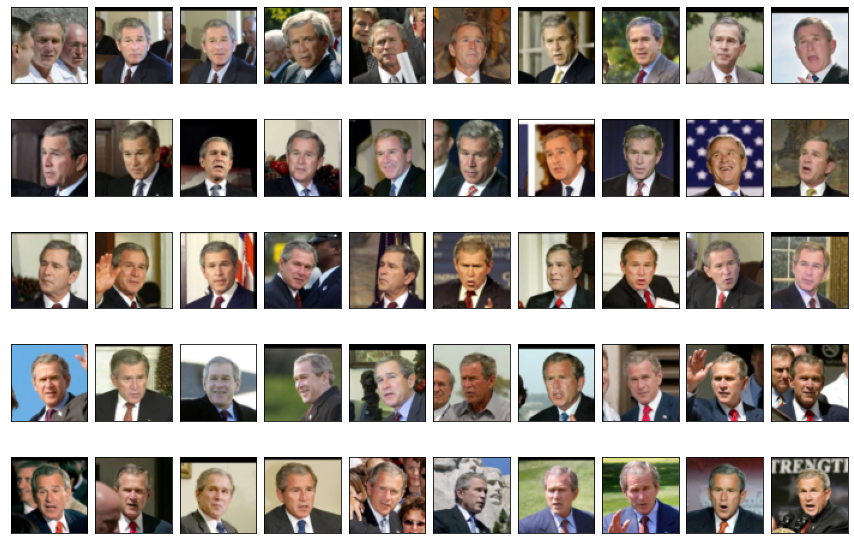

In [105]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    T.Resize((im_size, im_size)),
    T.ToTensor(),
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

Let's try the inception score model for sanity:

### Vanilla GAN

#### Creating the model

Let's start with implementing the **Dicriminator** as we did in hw3.

In [106]:
import project.gan as gan

x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

torch.Size([1, 3, 64, 64])
Discriminator(
  (encoder): EncoderCNN(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2, inplace=True)
      (9): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.2, inplace=True)
      (12): 

Implementing the **Generator**:

In [107]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

Generator(
  (preperation_layer): Sequential(
    (0): Linear(in_features=128, out_features=8192, bias=True)
    (1): Linear(in_features=8192, out_features=8192, bias=True)
  )
  (decoder): DecoderCNN(
    (cnn): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2, inplace=True)
   

Implementing the **Dicriminator loss function** and **Generator loss function**:

In [108]:
from project.gan import discriminator_loss_fn
from project.gan import generator_loss_fn

Implementing a **sample()** function:

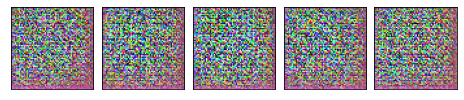

In [109]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

**Training**:

In [110]:
import torch.optim as optim
from torch.utils.data import DataLoader
from project.hyperparams import vanilla_gan_hyperparams

torch.manual_seed(42)
results_number = 0

# Hyperparams
hp = vanilla_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan_vanilla'
results_file = 'project/train_results/train_gan_vanilla'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 8, 'z_dim': 256, 'data_label': 1, 'label_noise': 0.1, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0003}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0003}}


In [111]:
import IPython.display
import tqdm
from project.gan import train_batch, save_checkpoint
from project.inception_score import inception_score
import pickle

num_epochs = 150
vanilla_scores = []
gen_train_mul_list = []
top_5_scores = []

if not is_train:
    print(f'*** Skipping training ***')
#     num_epochs = 0
#     gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
#     checkpoint_file = checkpoint_file_final
else:
    try:
        dsc_avg_losses, gen_avg_losses = [], []
        for epoch_idx in range(num_epochs):
            # We'll accumulate batch losses and show an average once per epoch.
            dsc_losses, gen_losses = [], []
            gen_train_mul = 1

            print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

            with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
                for batch_idx, (x_data, _) in enumerate(dl_train):
                    x_data = x_data.to(device)
                    if(gen_losses and dsc_losses):
                        gen_train_mul = int(abs(gen_losses[-1]-dsc_losses[-1])*2)
                    dsc_loss, gen_loss = train_batch(
                        dsc, gen,
                        dsc_loss_fn, gen_loss_fn,
                        dsc_optimizer, gen_optimizer,
                        x_data,
                        gen_train_mul)
                    dsc_losses.append(dsc_loss)
                    gen_losses.append(gen_loss)
                    pbar.update()

            gen_train_mul_list.append(gen_train_mul)
            dsc_avg_losses.append(np.mean(dsc_losses))
            gen_avg_losses.append(np.mean(gen_losses))
            samples = gen.sample(5, with_grad=False)
            score, _ = inception_score(samples, cuda=is_cuda, batch_size=2, resize=True)
            vanilla_scores.append(score)

            print(f'gen_train_mul: {gen_train_mul}')
            print(f'Discriminator loss: {dsc_avg_losses[-1]}')
            print(f'Generator loss:     {gen_avg_losses[-1]}')
            print(f'Inception Score:     {vanilla_scores[-1]}')

            if save_checkpoint(gen, score, epoch_idx, checkpoint_file, top_5_scores):
                print(f'Saved checkpoint.')

            if(epoch_idx % 10 == 0):
                fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
                IPython.display.display(fig)
                plt.close(fig)

        epoch_list = list(range(num_epochs))
        results = {
            "loss":{
                "dsc_loss":{'x':epoch_list, 'y':dsc_avg_losses},
                "gen_loss":{'x':epoch_list, 'y':gen_avg_losses},
            },
            "inception_score":{
                "score":{'x':epoch_list, 'y':vanilla_scores},
            }
        }

        while os.path.exists(results_file + str(results_number)):
            results_number += 1
        
        results_file_path = results_file + str(results_number)
        file = open(results_file_path, 'wb')
        pickle.dump({'hp': hp, 'results':results}, file)
        file.close()

    except KeyboardInterrupt as e:
        print('\n *** Training interrupted by user')

*** Skipping training ***


In [112]:
import matplotlib.pyplot as plt

def plot_experiment_results(results, nrows=0, ncols=0, fig=None):
    print(results['hp'])
    if nrows == 0 and ncols == 0:
        nrows = len(results.items())
        ncols = 1
    if fig is None:
        fig, _ = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(20,12))

    for i, (graph_name, graph_data) in enumerate(results['results'].items()):
        ax = fig.axes[i]
        for graph_label, graph in graph_data.items():
            ax.plot(graph['x'], graph['y'], label=graph_label)
        ax.set_title(graph_name)
        ax.set_xlabel('epoch')
        ax.legend()
    
    return fig

In [113]:
results_file_path = results_file + '_final'
vanilla_gan_dict_results = pickle.load(open(results_file_path, 'rb'))

### SN-GAN

**Training**:

Let's try to improve our model by adding the spectral_norm torch function to each layer in the vanilla GAN model.

In [114]:
from project.hyperparams import sn_gan_hyperparams

torch.manual_seed(42)
results_number = 0

# Hyperparams
hp = sn_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator_SN(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/sn_gan'
results_file = 'project/train_results/train_sn_gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 8, 'z_dim': 256, 'data_label': 1, 'label_noise': 0.2, 'discriminator_optimizer': {'type': 'Adam', 'lr': 5e-05, 'betas': (0.4, 0.9)}, 'generator_optimizer': {'type': 'Adam', 'lr': 5e-05, 'betas': (0.4, 0.9)}}


In [115]:
import IPython.display
import tqdm
from project.gan import train_batch, save_checkpoint
from project.inception_score import inception_score
import pickle

num_epochs = 150
vanilla_scores = []
gen_train_mul_list = []
top_5_scores = []
if not is_train:
    print(f'*** Skipping training ***')

else:
    try:
        dsc_avg_losses, gen_avg_losses = [], []
        for epoch_idx in range(num_epochs):
            # We'll accumulate batch losses and show an average once per epoch.
            dsc_losses, gen_losses = [], []
            gen_train_mul = 1

            print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

            with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
                for batch_idx, (x_data, _) in enumerate(dl_train):
                    x_data = x_data.to(device)
                    dsc_loss, gen_loss = train_batch(
                        dsc, gen,
                        dsc_loss_fn, gen_loss_fn,
                        dsc_optimizer, gen_optimizer,
                        x_data,
                        gen_train_mul)
                    dsc_losses.append(dsc_loss)
                    gen_losses.append(gen_loss)
                    pbar.update()

            gen_train_mul_list.append(gen_train_mul)
            dsc_avg_losses.append(np.mean(dsc_losses))
            gen_avg_losses.append(np.mean(gen_losses))
            samples = gen.sample(5, with_grad=False)
            score, _ = inception_score(samples, cuda=is_cuda, batch_size=2, resize=True)
            vanilla_scores.append(score)

            print(f'gen_train_mul: {gen_train_mul}')
            print(f'Discriminator loss: {dsc_avg_losses[-1]}')
            print(f'Generator loss:     {gen_avg_losses[-1]}')
            print(f'Inception Score:     {vanilla_scores[-1]}')

            if save_checkpoint(gen, score, epoch_idx, checkpoint_file, top_5_scores):
                print(f'Saved checkpoint.')

            if(epoch_idx % 10 == 0):
                fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
                IPython.display.display(fig)
                plt.close(fig)
        epoch_list = list(range(num_epochs))
        results = {
            "loss":{
                "dsc_loss":{'x':epoch_list, 'y':dsc_avg_losses},
                "gen_loss":{'x':epoch_list, 'y':gen_avg_losses},
            },
            "inception_score":{
                "score":{'x':epoch_list, 'y':vanilla_scores},
            }
        }

        while os.path.exists(results_file + str(results_number)):
            results_number += 1

        results_file_path = results_file + str(results_number)
        file = open(results_file_path, 'wb')
        pickle.dump({'hp': hp, 'results':results}, file)
        file.close()

    except KeyboardInterrupt as e:
        print('\n *** Training interrupted by user')

*** Skipping training ***


In [116]:
results_file_path = results_file + '_final'
sn_gan_dict_results = pickle.load(open(results_file_path, 'rb'))

### WGAN

**TODO:**
add explanation

**Training**

In [117]:
import torch.optim as optim
from torch.utils.data import DataLoader
from project.hyperparams import vanilla_gan_hyperparams

torch.manual_seed(42)
results_number = 0

# Hyperparams
hp = sn_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.wgan_discriminator_loss_fn(y_data, y_generated)

def gen_loss_fn(y_generated):
    return gan.wgan_generator_loss_fn(y_generated)

# Training
checkpoint_file = 'checkpoints/wgan'
results_file = 'project/train_results/train_wgan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 8, 'z_dim': 256, 'data_label': 1, 'label_noise': 0.2, 'discriminator_optimizer': {'type': 'Adam', 'lr': 5e-05, 'betas': (0.4, 0.9)}, 'generator_optimizer': {'type': 'Adam', 'lr': 5e-05, 'betas': (0.4, 0.9)}}


In [118]:
import IPython.display
import tqdm
from project.gan import train_batch, save_checkpoint
from project.inception_score import inception_score
import pickle

num_epochs = 150
vanilla_scores = []
gen_train_mul_list = []
top_5_scores = []

if not is_train:
    print(f'*** Skipping training ***')
else:
    try:
        dsc_avg_losses, gen_avg_losses = [], []
        for epoch_idx in range(num_epochs):
            # We'll accumulate batch losses and show an average once per epoch.
            dsc_losses, gen_losses = [], []
            gen_train_mul = 1

            print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

            with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
                for batch_idx, (x_data, _) in enumerate(dl_train):
                    x_data = x_data.to(device)
                    dsc_loss, gen_loss = train_batch(
                        dsc, gen,
                        dsc_loss_fn, gen_loss_fn,
                        dsc_optimizer, gen_optimizer,
                        x_data,
                        gen_train_mul)
                    dsc_losses.append(dsc_loss)
                    gen_losses.append(gen_loss)
                    pbar.update()

            gen_train_mul_list.append(gen_train_mul)
            dsc_avg_losses.append(np.mean(dsc_losses))
            gen_avg_losses.append(np.mean(gen_losses))
            samples = gen.sample(5, with_grad=False)
            score, _ = inception_score(samples, cuda=is_cuda, batch_size=2, resize=True)
            vanilla_scores.append(score)

            print(f'gen_train_mul: {gen_train_mul}')
            print(f'Discriminator loss: {dsc_avg_losses[-1]}')
            print(f'Generator loss:     {gen_avg_losses[-1]}')
            print(f'Inception Score:     {vanilla_scores[-1]}')

            if save_checkpoint(gen, score, epoch_idx, checkpoint_file, top_5_scores):
                print(f'Saved checkpoint.')

            
            fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
            IPython.display.display(fig)
            plt.close(fig)
        epoch_list = list(range(num_epochs))
        results = {
            "loss":{
                "dsc_loss":{'x':epoch_list, 'y':dsc_avg_losses},
                "gen_loss":{'x':epoch_list, 'y':gen_avg_losses},
            },
            "inception_score":{
                "score":{'x':epoch_list, 'y':vanilla_scores},
            }
        }

        while os.path.exists(results_file + str(results_number)):
            results_number += 1

        results_file_path = results_file + str(results_number)
        file = open(results_file_path, 'wb')
        pickle.dump({'hp': hp, 'results':results}, file)
        file.close()

    except KeyboardInterrupt as e:
        print('\n *** Training interrupted by user')

*** Skipping training ***


In [119]:
results_file_path = results_file + '_final'
wgan_dict_results = pickle.load(open(results_file_path, 'rb'))

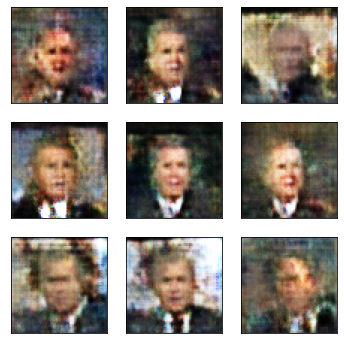

In [120]:
checkpoint_file = 'checkpoints/wgan'
checkpoint_file_name = checkpoint_file + '_140_1.6865863069790374.pt'
base_samples_file = 'project/train_results/'
gen = torch.load(f'{checkpoint_file_name}', map_location=device)
samples = gen.sample(9, with_grad=False)
fig, _ = plot.tensors_as_images(samples.cpu(), nrows=3, figsize=(6,6))
# torch.save(samples, f'{base_samples_file}wgan_1.68_samples')
IPython.display.display(fig)
plt.close(fig)

### Presenting The Results
#### Vanilla Gan

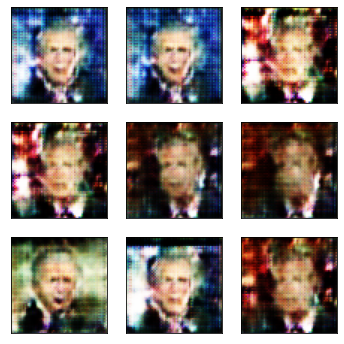

{'batch_size': 8, 'z_dim': 256, 'data_label': 1, 'label_noise': 0.1, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0003}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0003}}


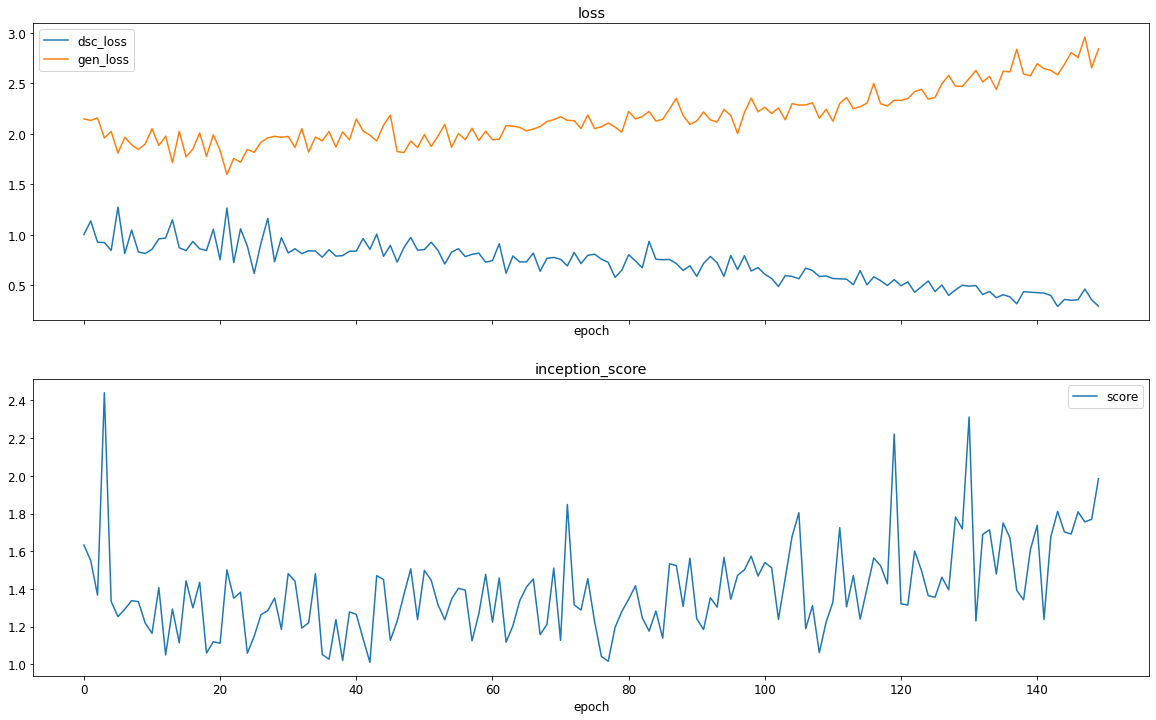

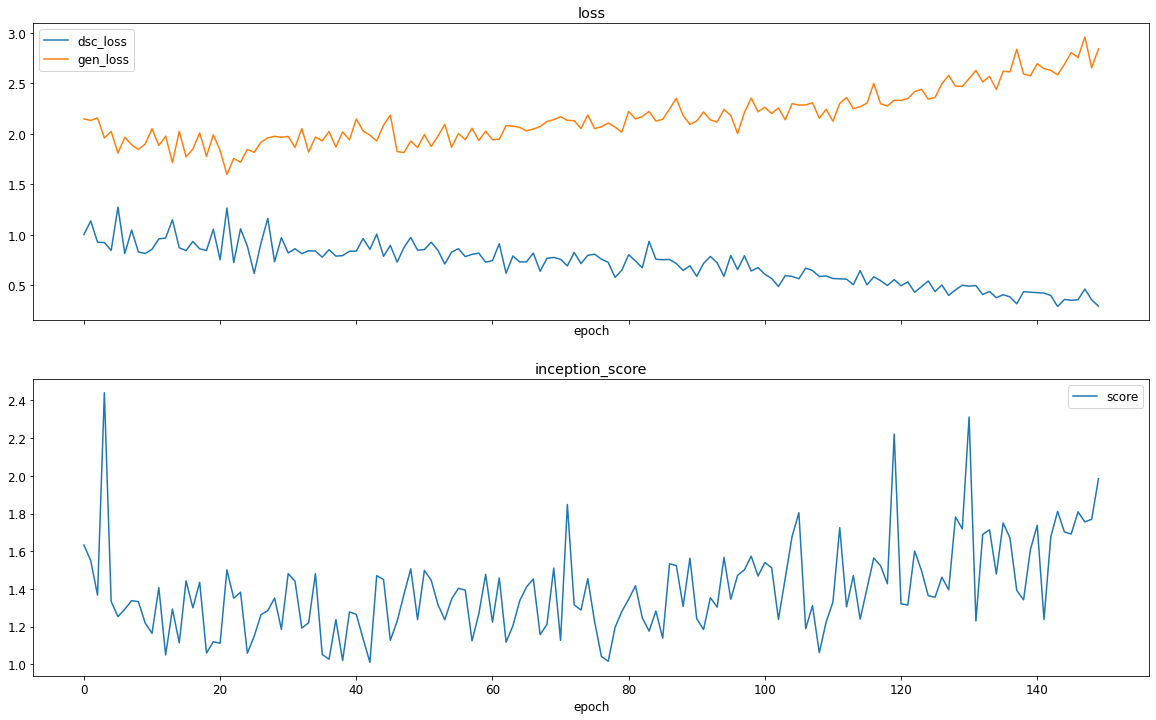

In [128]:
samples = torch.load(f'project/train_results/vanilla_gan_2.3_samples', map_location=device)
fig, _ = plot.tensors_as_images(samples.cpu(), nrows=3, figsize=(6,6))
IPython.display.display(fig)
plt.close(fig)
plot_experiment_results(vanilla_gan_dict_results)

#### SN Gan

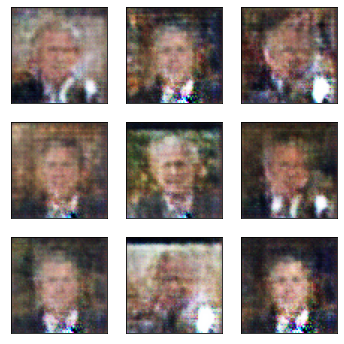

{'batch_size': 8, 'z_dim': 256, 'data_label': 1, 'label_noise': 0.2, 'discriminator_optimizer': {'type': 'Adam', 'lr': 5e-05, 'betas': (0.4, 0.9)}, 'generator_optimizer': {'type': 'Adam', 'lr': 5e-05, 'betas': (0.4, 0.9)}}


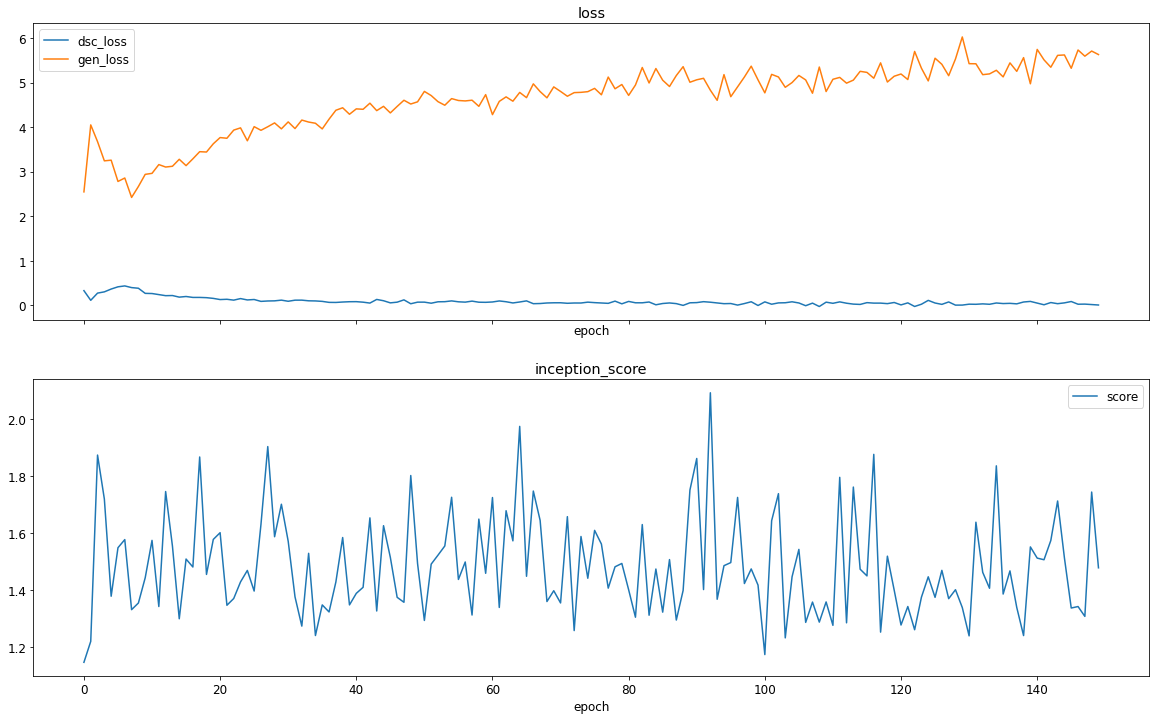

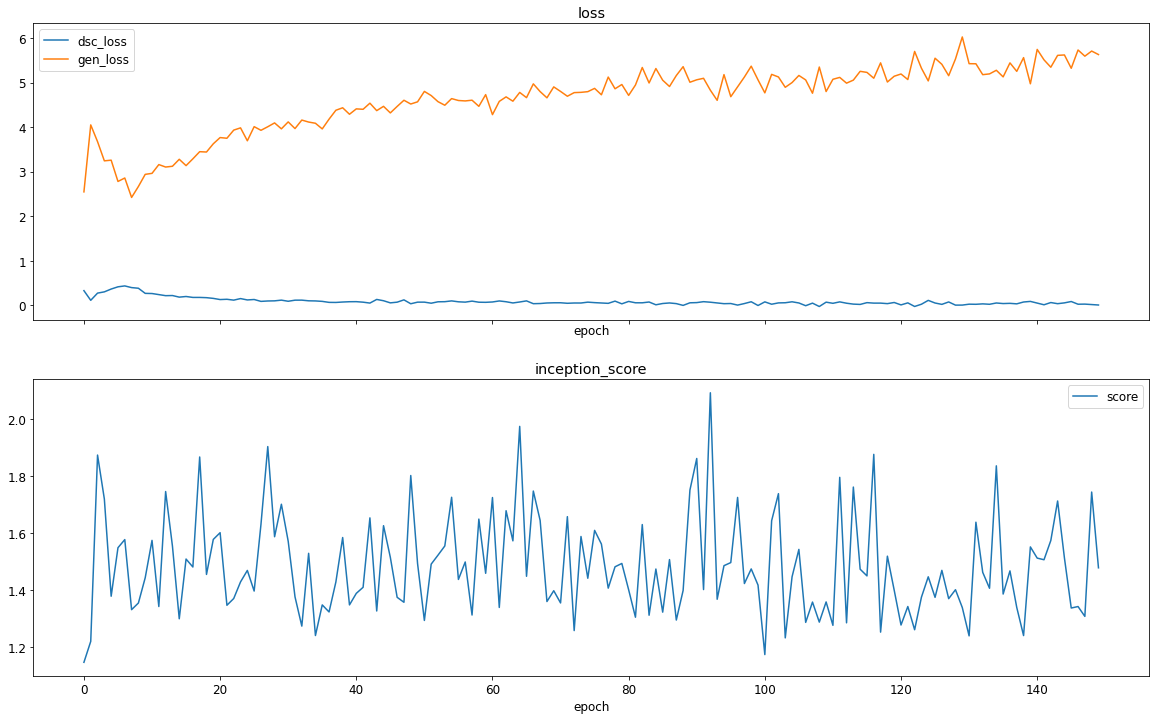

In [133]:
samples = torch.load(f'project/train_results/sn_gan_2.09_samples', map_location=device)
fig, _ = plot.tensors_as_images(samples.cpu(), nrows=3, figsize=(6,6))
IPython.display.display(fig)
plt.close(fig)
plot_experiment_results(sn_gan_dict_results)

#### WGAN

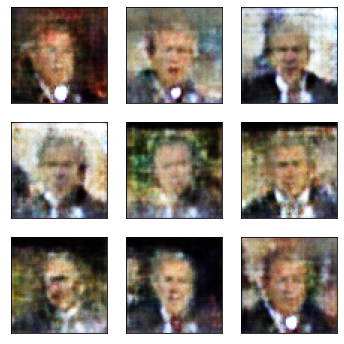

{'batch_size': 8, 'z_dim': 256, 'data_label': 1, 'label_noise': 0.2, 'discriminator_optimizer': {'type': 'Adam', 'lr': 5e-05, 'betas': (0.4, 0.9)}, 'generator_optimizer': {'type': 'Adam', 'lr': 5e-05, 'betas': (0.4, 0.9)}}


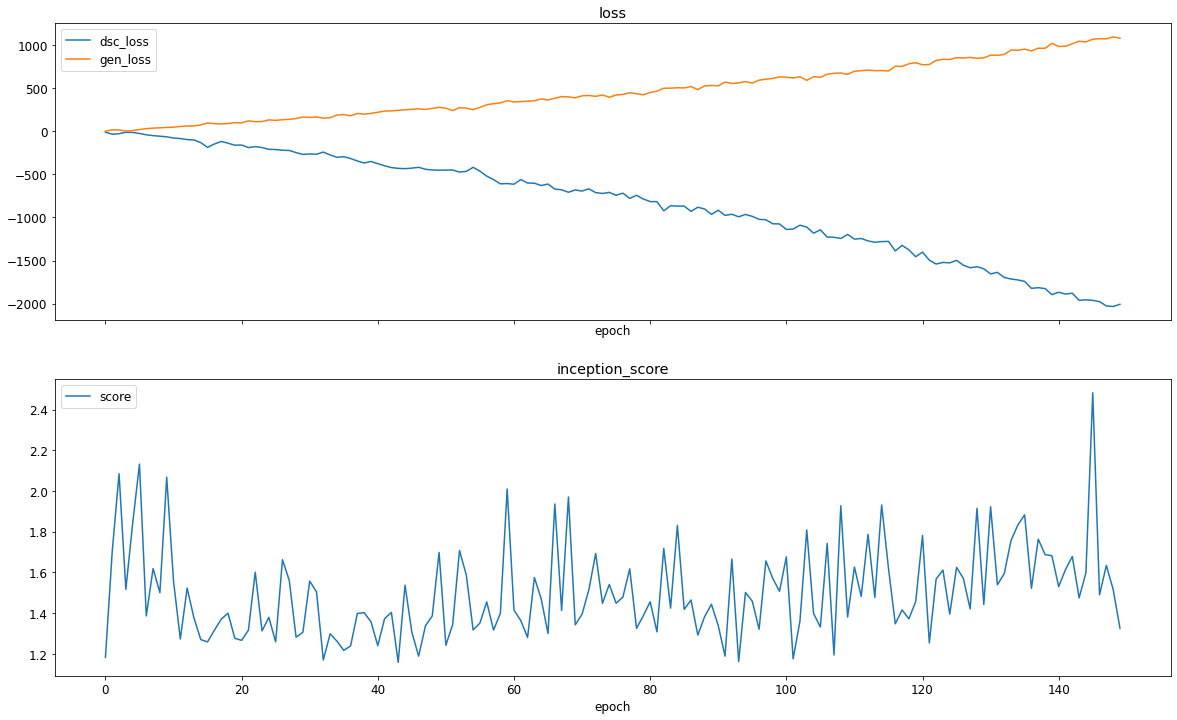

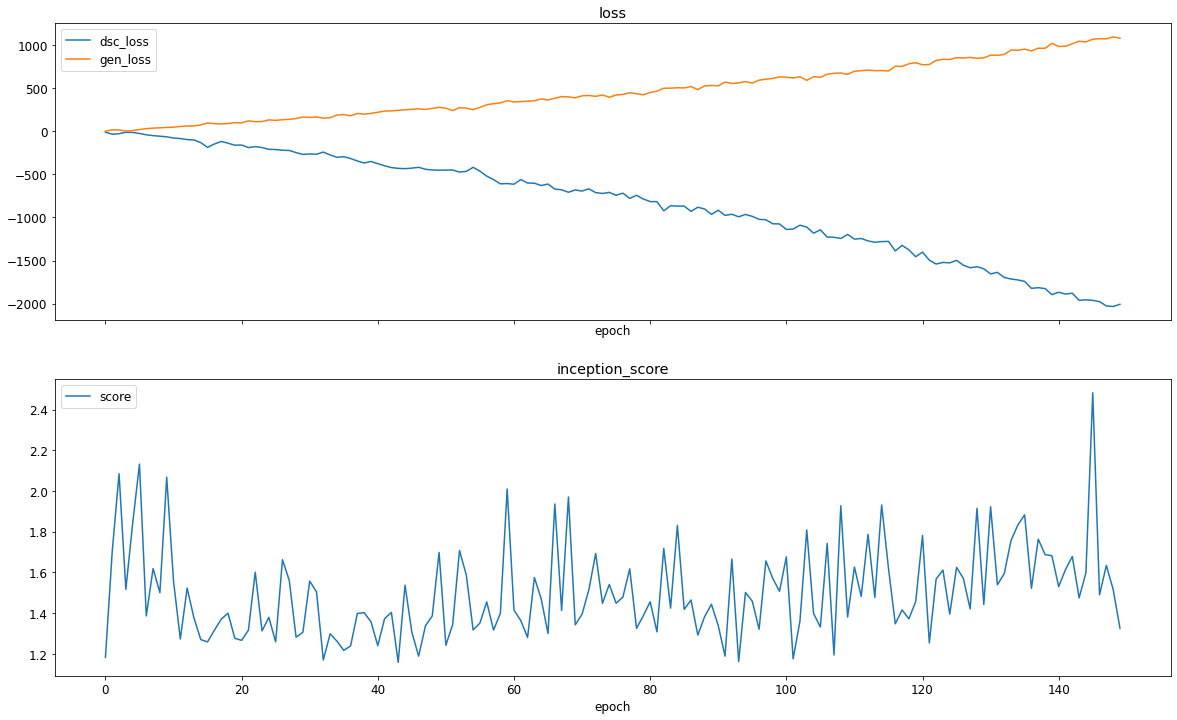

In [135]:
samples = torch.load(f'project/train_results/wgan_1.96_samples', map_location=device)
fig, _ = plot.tensors_as_images(samples.cpu(), nrows=3, figsize=(6,6))
IPython.display.display(fig)
plt.close(fig)
plot_experiment_results(wgan_dict_results)

### Conclusions

Notes:
* inception score not good - compare the score of the real images from the fake ones (fake beter) present the samples from the vanilla that has a score 2.4 and show that they are really bad
* training time - vanilla + sn same, wgan longer (X2) why?
* ?training trick - number of gen steps for each dsc step with coroletion to the loss diffrences
* gen reaches his pick and the dsc keeps improving - incresing the deferences between the losses (all models)
